In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# FRED API Key (Get one from https://fred.stlouisfed.org/)
FRED_API_KEY = "32d1fa37c639637c4fbf10df162df251"

# Indicators to Fetch (FRED Series IDs)
INDICATORS = {
    "GDP": "GDP",  # Gross Domestic Product
    "Unemployment Rate": "UNRATE",  # Unemployment Rate
    "CPI (Inflation)": "CPIAUCSL",  # Consumer Price Index
    "PCE (Inflation)": "PCE",       # Personal Consumption Expenditures Price Index
    "Federal Funds Rate": "FEDFUNDS",  # Interest Rate
    "S&P 500 Index": "SP500",  # Stock Market Index
    "Trade Balance": "BOPGSTB",  # Trade Balance
    "10-Year Treasury Yield": "DGS10",  # 10-Year Treasury Bond Yield
    "M2 Money Supply": "M2SL",
    "Corporate Profits": "CP",
    "Consumer Sentiment": "UMCSENT"
}

START_DATE = "2024-01-01"

# Fetch S&P 500 data from Yahoo Finance (2000-Present)
def fetch_sp500_data():
    sp500 = yf.Ticker("^GSPC")
    df = sp500.history(start=START_DATE)  # Get all available data
    df = df[["Close"]].rename(columns={"Close": "value"})  # Keep only the closing price
    df.index = pd.to_datetime(df.index)  # Convert index to datetime
    return df

# Fetch data from FRED API
def fetch_fred_data(series_id):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": START_DATE
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    if "observations" in data:
        df = pd.DataFrame(data["observations"])
        df["date"] = pd.to_datetime(df["date"])
        df = df[df["value"] != "."]  # Remove invalid values
        df["value"] = df["value"].astype(float)  # Convert to float
        return df.set_index("date")
    else:
        print(f"Error fetching {series_id}")
        return None

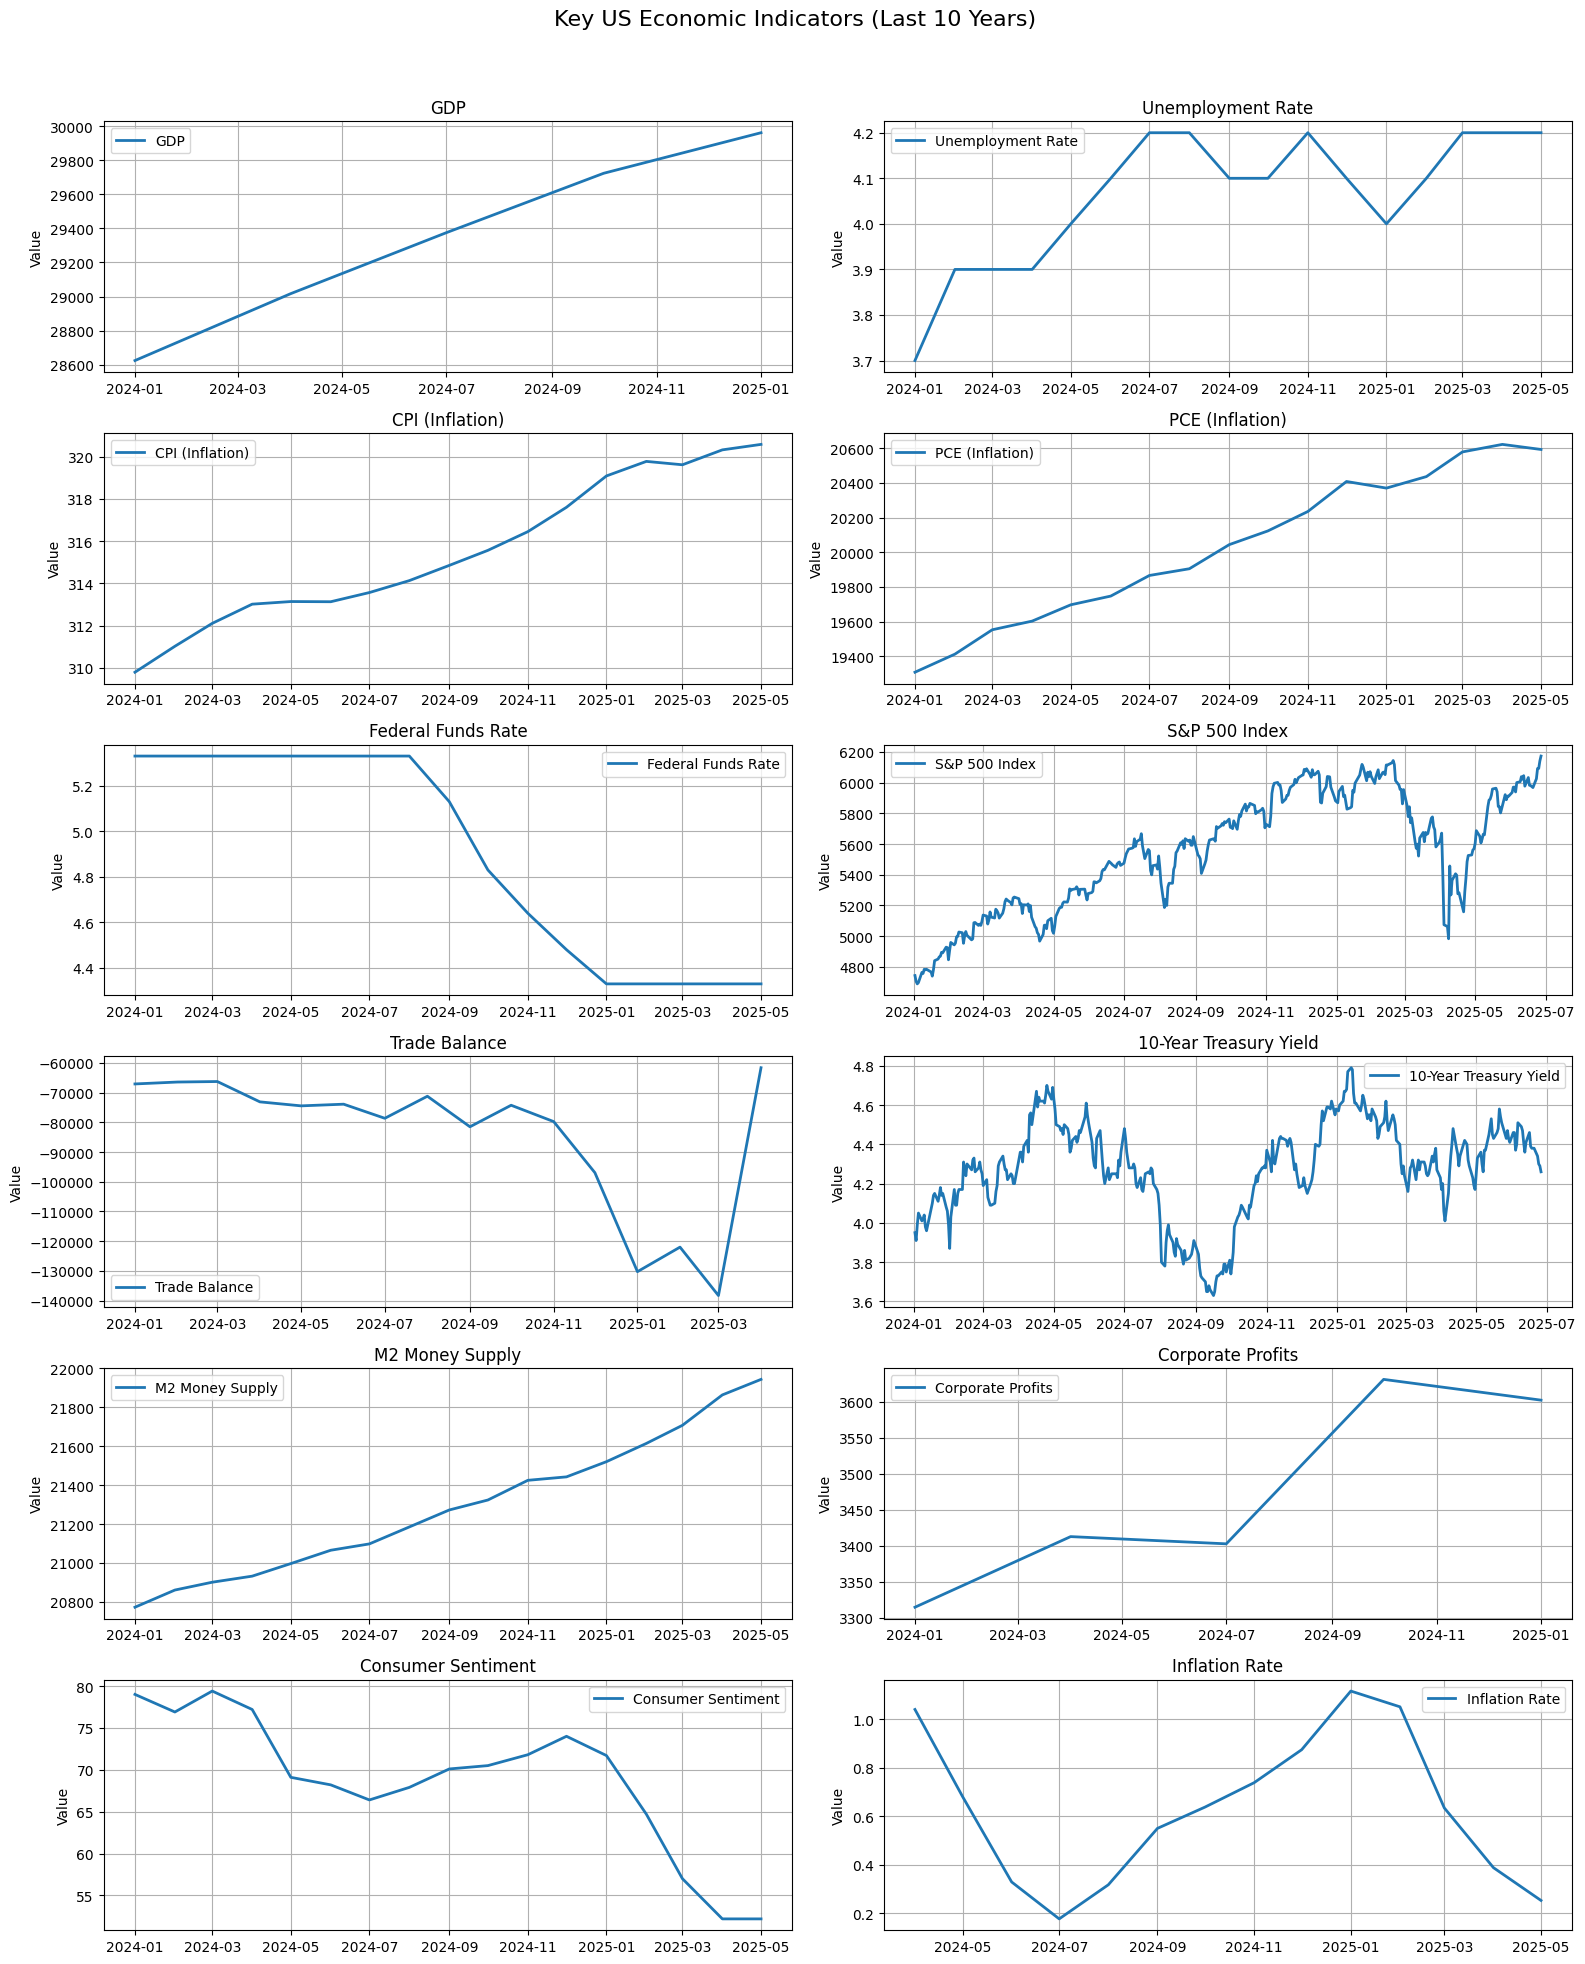

In [3]:
# Fetch all indicators
data_frames = {name: fetch_fred_data(series_id) for name, series_id in INDICATORS.items()}

# Fetch S&P 500 data
data_frames["S&P 500 Index"] = fetch_sp500_data()

# Calculate Inflation Rate (Year-over-Year % Change in CPI)
if data_frames["CPI (Inflation)"] is not None:
    df_cpi = data_frames["CPI (Inflation)"].copy()
    df_cpi["value"] = df_cpi["value"].pct_change(periods=3) * 100  # 12-month percentage change
    data_frames["Inflation Rate"] = df_cpi[["value"]]  # Store as new indicator
    #print(data_frames)

# Plot each indicator
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 20))
fig.suptitle("Key US Economic Indicators (Last 10 Years)", fontsize=16)

for ax, (name, df) in zip(axes.flatten(), data_frames.items()):
    if df is not None:
        #ax.plot(df.index, df.iloc[:, 0], label=name, linewidth=2)
        ax.plot(df.index, df["value"], label=name, linewidth=2)
        ax.set_title(name)
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()